In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from kyle.calibration import ModelCalibrator
from kyle.models import CalibratableModel
from kyle.metrics import ECE
from kyle.calibration.calibration_methods import TemperatureScaling
from kyle.sampling.fake_clf import DirichletFC
from kyle.transformations import MaxComponentSimplexAut
from kyle.evaluation import EvalStats

# What is calibration?

When we talk about how good a machine learning model is, what we (generally) mean to ask is: How accurate is the model?
While this is a good enough metric in many cases, we are, in fact, leaving out important information about the model.
One such piece of information is concerned with whether the confidence of the model is in line with its accuracy.
If it is, we say the model is calibrated.

To explain this concept in detail, let's begin with an example. Suppose we want to predict whether a patient has cancer.
We can simulate data with two classes i.e. $y \in \{0, 1\}$ where $y=0$ denotes a healthy patient and $y=1$ denotes a
patient who has cancer.

In [3]:
n_samples = 2000
n_classes = 3

In [4]:
X, y = datasets.make_classification(
    n_samples=n_samples,
    n_features=20,
    n_informative=7,
    n_redundant=10,
    n_classes=n_classes,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

We can then train a neural network on our data:

In [5]:
model = MLPClassifier(hidden_layer_sizes=(20, 20, 10))
model.fit(X_train, y_train)

/home/runner/work/kyle/kyle/.tox/py/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(20, 20, 10))

and make predictions on new samples. Let's see how our model performs on unseen examples:

In [6]:
y_pred = model.predict(X_test)
model_accuracy = accuracy_score(y_test, y_pred)

f"Model accuracy: {model_accuracy*100}%"

'Model accuracy: 85.39999999999999%'

That seems pretty good! One might think our job here is done: After all, the model predicts whether a person has cancer
or not with decent accuracy.
Unfortunately, accuracy of a model does not tell us the full story. This is so due to the fact that at inference time, 
for a given sample a model outputs confidence scores for each class. We then take the class with the highest confidence
and interpret that as the prediction of the model.

This conversion of continuous (probability) to discrete (label) values can hide certain properties of the model.
To illustrate this, let's take two models -- $A$ and $B$ -- trained on the same data. Let's further assume they have
similar accuracy. Suppose we test both models with 10 healthy samples. $A$ assigns probabilities $(0.49, 0.51)$ to all
samples, whereas $B$ assigns $(0.1, 0.9)$. While $A$ & $B$ will be wrong 100% of the time, notice $A$ being much closer
to classifying the samples as belonging to the correct class compared to $B$.

Continuing with our previous example: Imagine that on all examples where the model was $95$% confident that the subject 
has cancer, it was correct $70$% of the time. Intuitively, it seems there's something not quite right with the model:
the model is over-confident in its predictions. This notion is formalized by the concept of calibration.
We say a model is (strongly) calibrated when, for any confidence value $p \in [0, 1]$,
prediction of a class with confidence $p$ is correct with probability $p$:

\begin{equation}
P(\widehat{y}=y|\widehat{p}=p) = p \quad \forall p \in [0, 1]
\end{equation}

So, is our model calibrated? As we can see in the equation above, $\widehat{p}$ is continuous, which means we cannot
compute the equation with finite data. We can, however, develop empirical measures that approximate the true measure
of (mis)calibration.

One simple way to get an empirical estimate of the model's accuracy and confidence is to discretize the probability
space. This is done by slicing $p$ into $K$ equal-sized bins. We can then calculate the accuracy and confidence for each
bin:

\begin{equation}
accuracy_{B_k} = \frac{1}{|B_k|} \sum_{m=1}^{|B_k|}1(\widehat{p}_m=p_m)
\end{equation}

\begin{equation}
confidence_{B_k} = \frac{1}{|B_k|} \sum_{m=1}^{|B_k|}\widehat{p}_m
\end{equation}

We can now simply calculate the weighted average difference between the accuracy and confidence of the model over all bins:

\begin{equation}
\sum_{k=1}^{K} \frac{|B_k|}{n} \Big|\:accuracy_{B_k} - confidence_{B_k} \Big|
\end{equation}

This is known as the **Expected Calibration Error** $(ECE).$ As can be seen, $ECE=0$ if a model is perfectly calibrated.
Let's calculate the $ECE$ for our model with $10$ bins:

In [7]:
ece = ECE(bins=12)

In [8]:
# Evaluate uncalibrated predictions
y_pred = model.predict_proba(X_test)

pre_calibration_ece = ece.compute(y_pred, y_test)

f"ECE before calibration: {pre_calibration_ece}"

'ECE before calibration: 0.09662671533310493'

We can also visualize the extent of miscalibration by plotting the model's confidence *(x-axis)* vs. the ground truth
probability *(y-axis)*. For a perfectly calibrated model, the plot should be $y=x$. Let's see how our model fares:

In [9]:
eval_stats = EvalStats(y_test, y_pred)
class_labels = range(n_classes)

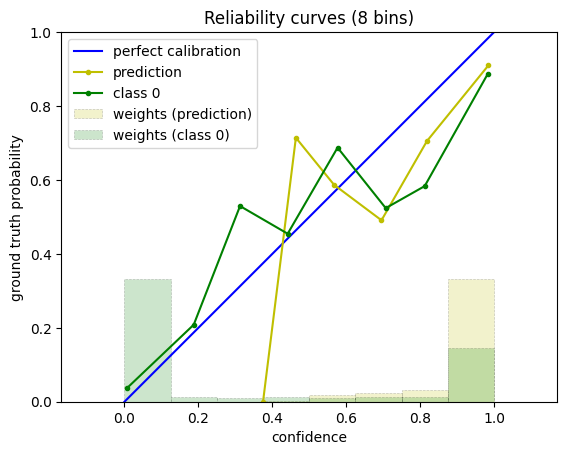

In [10]:
fig = eval_stats.plot_reliability_curves(
    ["top_class", 0], display_weights=True, strategy="uniform", n_bins=8
)

The density of predictions is distributed highly inhomogeneously on the unit interval, some bins have
few members and the estimate of the reliability has high variance. This can be helped by employing
the "quantile" binning strategy, also called adaptive binning

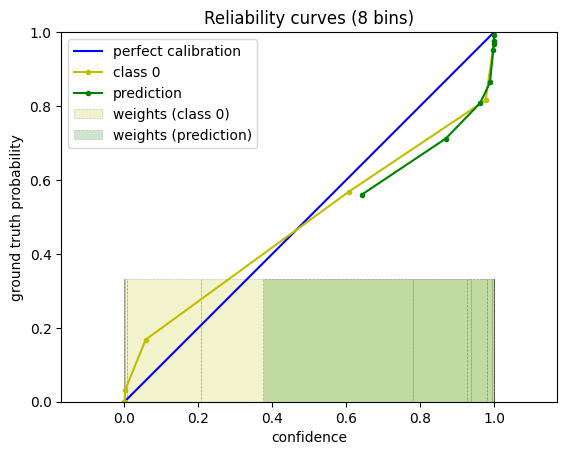

In [11]:
fig = eval_stats.plot_reliability_curves(
    [0, "top_class"], display_weights=True, n_bins=8, strategy="quantile"
)

Now all bins have the same weight but different width. The pointwise reliability estimates
have lower variance but there are wide gaps, thus requiring more interpolation.
Both binning strategies have their advantages and disadvantages.

Okay, so our model is not calibrated as $ECE>0$. Can we do anything to remedy the situation?

# Model calibration

Indeed, we can improve the calibration of our model using various techniques. What's more, we don't need to train our
model again; many calibration techniques are post-processing methods i.e. operating on the trained model's output
confidence scores. The output scores for calibration are typically obtained on a validation set.

In `kyle`, we have provided a `CalibratableModel` class which takes a model and, as the name suggests, makes it possible
to calibrate that model. By default, we use a technique called [*Temperature scaling*](https://arxiv.org/abs/1706.04599)
for calibration.

In [12]:
# Create calibratable model
calibration_method = TemperatureScaling()
calibratable_model = CalibratableModel(model, calibration_method)

We also provide a `ModelCalibrator` class which holds the data to calibrate models:

In [13]:
# Create model calibrator and calibrate model
calibrator = ModelCalibrator(
    X_calibrate=X_test, y_calibrate=y_test, X_fit=X_train, y_fit=y_train
)

We now have everything ready to calibrate our model:

In [14]:
calibrator.calibrate(calibratable_model)

Let's see if calibrating the model improved the $ECE$ score

In [15]:
# Passing X_test instead of X_calibrate in predict_proba() to make comparison with pre-calib model clear,
# same reasong for y_test in ece.compute()
calibrated_confidences = calibratable_model.predict_proba(X_test)

post_calibration_ece = ece.compute(calibrated_confidences, y_test)

f"ECE before calibration: {pre_calibration_ece}, ECE after calibration: {post_calibration_ece}"

'ECE before calibration: 0.09662671533310493, ECE after calibration: 0.020610631316900222'

Great! $ECE$ has improved. Let's also plot a reliability curve to visually confirm the improvement in calibration.

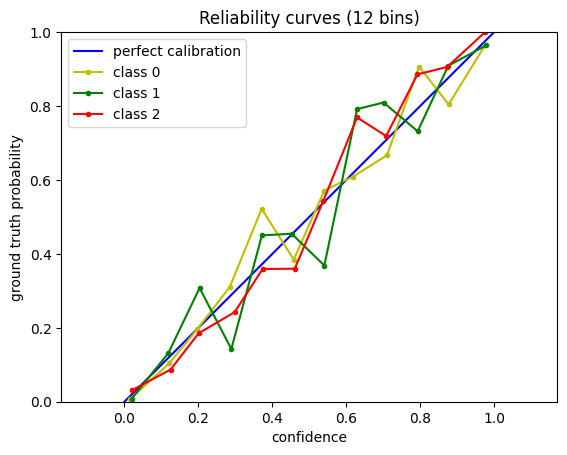

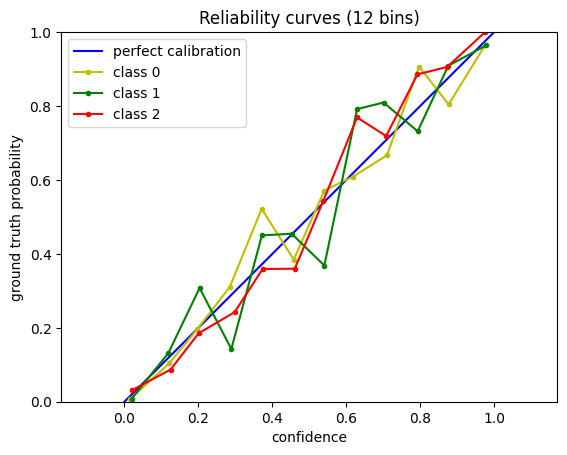

In [16]:
eval_stats = EvalStats(y_test, calibrated_confidences)

eval_stats.plot_reliability_curves(class_labels)

Wonderful! We have successfully improved our model's calibration.

# Model-agnostic calibration

You may have noticed that to evaluate (mis)calibration of a model, we don't require the model itself.
Rather, it is sufficient to have the confidence scores predicted by the model.
This means we can abstract away the model and generate both the ground truth and confidence scores via sampling processes.

In `kyle` we have provided samplers that simulate different kinds of calibration properties.
One such sampler is the `DirichletFC` class which provides calibrated ground truth and confidences by default.

In [17]:
sampler = DirichletFC(num_classes=2)

# Get 1000 calibrated fake confidence scores
calibrated_samples = sampler.get_sample_arrays(1000)
ground_truth, confidences = calibrated_samples

Let's evaluate the $ECE$ for these samples:

In [18]:
ece.compute(confidences, ground_truth)

0.021226959445605285

Wait, the $ECE>0$, how can we say that the samples are calibrated?

As mentioned earlier, we only have finite samples so true miscalibration can only be measured asymptotically.
This means that the more samples we have, the more accurate would $ECE$'s estimate become.
We can test this by generating *5x* as many samples as before and evaluating $ECE$ again:

In [19]:
calibrated_samples = sampler.get_sample_arrays(5000)
ground_truth, confidences = calibrated_samples

ece.compute(confidences, ground_truth)

0.012946787951753537

As expected, $ECE$ goes down with more samples.

We can also systematically generate uncalibrated samples. For instance, the `ShiftingSimplexAutomorphism` shifts the
confidence scores by adding a fixed vector with positive entries to the input and normalizing the result.

In [20]:
def overestimating_max(x: np.ndarray):
    x = x.copy()
    mask = x > 1 / 2
    x[mask] = x[mask] - (1 / 4 - (1 - x[mask]) ** 2)
    return x


automorphism = MaxComponentSimplexAut(overestimating_max)
shifted_sampler = DirichletFC(num_classes=2, simplex_automorphism=automorphism)

# Get 1000 uncalibrated fake confidence scores
uncalibrated_samples = shifted_sampler.get_sample_arrays(10000)
ground_truth, confidences = uncalibrated_samples

Let's see if the uncalibrated nature of the samples is validated by $ECE$:

In [21]:
ece.compute(confidences, ground_truth)

0.17290483432707532